In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model  import LogisticRegression, LinearRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score , mean_squared_error, r2_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p1.csv')
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=B,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=B,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=B,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=B,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=B,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [3]:
print(df.isna().sum())

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


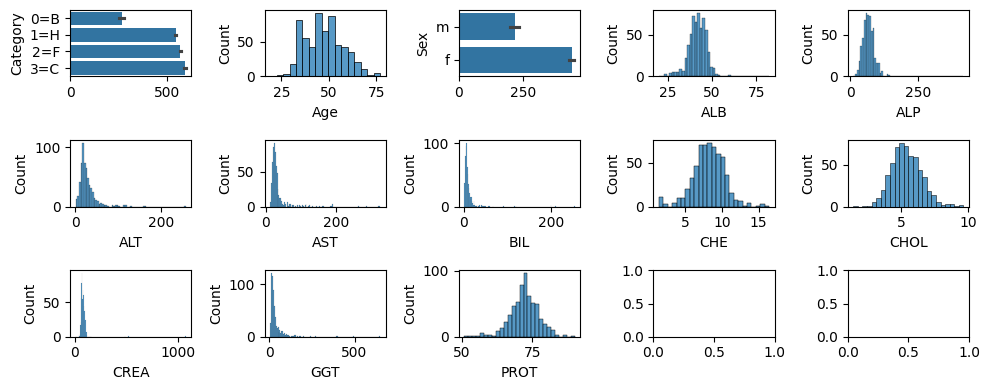

In [4]:
## 데이터 분포 확인하기 

fig, axes = plt.subplots(3,5, figsize = (10, 4)) 

for i, axes in enumerate(axes.flat[: len(df.columns)]) : 
    col_i = df.columns[i]
    if df[col_i].dtype == 'object' : 
        sns.barplot(df[col_i], ax= axes)

    else : 
        sns.histplot(df[col_i], ax = axes)

plt.tight_layout()
plt.show()

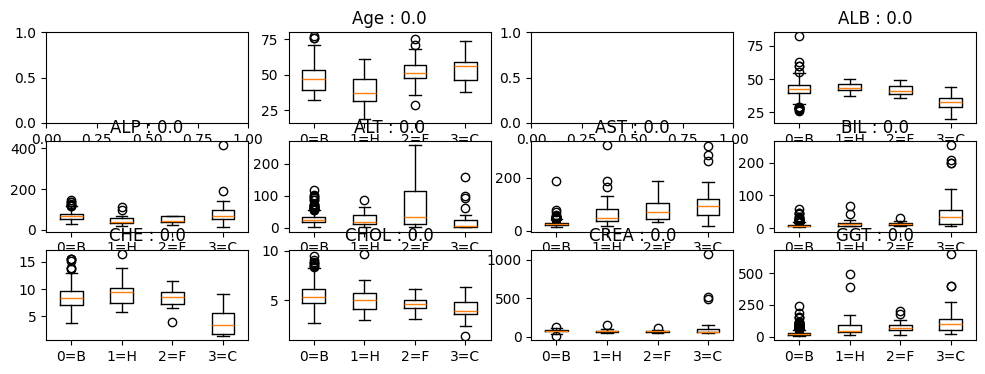

<Figure size 640x480 with 0 Axes>

In [5]:
# 평균 대체 
import scipy.stats as stats

df_mean = df.copy()
for col in df_mean.columns: 
    if df_mean[col].isna().sum() > 0 : 
        df_mean[col] = df_mean[col].fillna(df_mean[col].mean())

#print(df_mean.isna().sum())

fig, axes = plt.subplots(3, 4, figsize = (12, 4))
for i, axes in enumerate(axes.flat[:len(df_mean.columns)]) : 
    col_i = df.columns[i]
    # ANOVA 
    if df_mean[col_i].dtype != 'object' : 
        groups = [df_mean[df_mean['Category'] == cat][col_i] for cat in df_mean['Category'].unique()]
    
        f_, p_ = stats.f_oneway(* groups)
        axes.boxplot(groups, labels = df_mean['Category'].unique())
        axes.set_title(f'{col_i} : {round(p_,5)}')

plt.show()
plt.tight_layout()
#enumerate(axes.flat[: len(df.columns)]) : 

<Axes: >

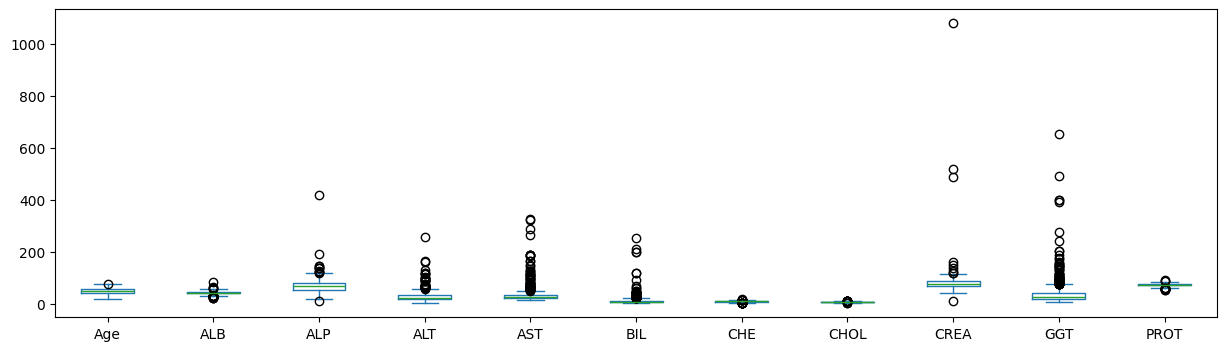

In [6]:
# 이상치 처리 후 처리 여부 판단 작업 

num_col = df_mean.select_dtypes(exclude = 'object').columns

df_mean[num_col].plot(kind = 'box', figsize = (15, 4))

<Axes: >

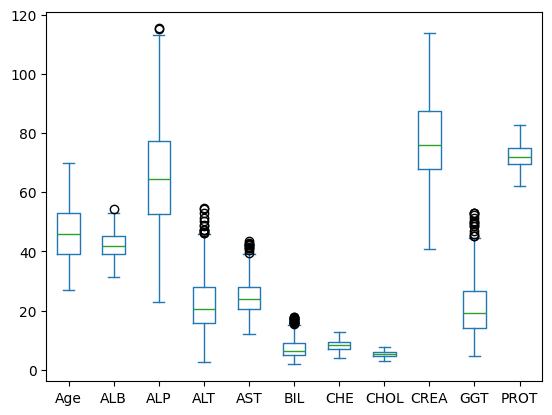

In [7]:
# iqr 

def remove_iqr(df, columns):
    df = df.copy()  # 원본 보호
    for col in columns:
        if df[col].dtype != 'object':
            q3 = df[col].quantile(0.75)
            q1 = df[col].quantile(0.25)
            iqr = q3 - q1

            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            df = df[(df[col] >= lower ) & (df[col] <= upper)]
    return df


num_col = df_mean.select_dtypes(exclude = 'object').columns
iqr_df = remove_iqr(df_mean, num_col)
iqr_df[num_col].plot(kind = 'box')

In [8]:
res = []

for col in df_mean.columns[df_mean.columns != 'Category' ] : 
    if col == 'Sex' : 
        cross = pd.crosstab(df_mean[col] , df['Category']) 
        stat, p_val , dof, expected = stats.chi2_contingency(cross)
        res.append([col, p_val])
    else : 
        groups = [df_mean[df_mean['Category'] == cat][col] for cat in df_mean['Category'].unique() ]
        f_, p_val = stats.f_oneway(*groups)
        res.append([col, p_val])

res = pd.DataFrame(res, columns = ['Columns','P_value'])
res['Check']=  res['P_value'].map(lambda x : '유의' if x < 0.05 else '유의하지않음')
res

,Columns,P_value,Check
0,Age,9.425871e-08,유의
1,Sex,1.193555e-01,유의하지않음
2,ALB,5.808575e-21,유의
3,ALP,3.443465e-11,유의
4,ALT,2.507966e-11,유의
5,AST,4.194864e-74,유의
6,BIL,4.000225e-48,유의
7,CHE,3.336676e-32,유의
8,CHOL,9.641726e-13,유의
9,CREA,2.680767e-09,유의


In [9]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_mean['Sex'] = df_mean['Sex'].map(lambda x : 1 if x == 'm' else 0 ).astype(int)
X = df_mean.drop(columns = ['Category', 'Sex'], axis = 1)


vif = pd.DataFrame()
vif['columns'] = X.columns

vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# Corr 
cor_mat = X.corr().unstack().to_frame().reset_index()
cor_mat.loc[(cor_mat['level_0'] != cor_mat['level_1'] ) & (cor_mat.iloc[:,2]).notna()]

# PCA 

   columns         vif
0      Age   22.579599
1      ALB   91.006168
2      ALP   10.957113
3      ALT    3.058739
4      AST    3.523528
5      BIL    1.666671
6      CHE   23.830276
7     CHOL   32.349693
8     CREA    3.784577
9      GGT    2.612289
10    PROT  141.423451


,level_0,level_1,0
1,Age,ALB,-0.169697
2,Age,ALP,0.160915
3,Age,ALT,-0.042072
4,Age,AST,0.073111
5,Age,BIL,0.035758
...,...,...,...
115,PROT,BIL,-0.057060
116,PROT,CHE,0.283447
117,PROT,CHOL,0.161204
118,PROT,CREA,-0.061960


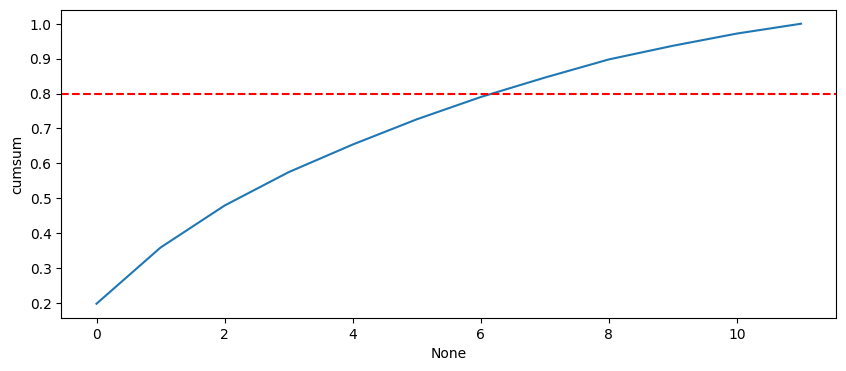

In [10]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 

s_df = df_mean.copy()
s_df['Category'] = s_df['Category'].str.split('=', expand = True)[0].astype(int)
s_df


s_X  = s_df.iloc[:,1:]

ss = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(s_X) , columns = s_X.columns) 


pca = PCA()
pca.fit(scaled_x)

p_df = pd.DataFrame({
    'ratio' : pca.explained_variance_ratio_, 
    'cumsum' : pca.explained_variance_ratio_.cumsum()
})


plt.figure(figsize = (10, 4))
sns.lineplot(x = p_df.index, y = p_df['cumsum'])
plt.axhline(0.8, color = 'red', linestyle = '--')


In [11]:
# 주성분 6  
s_X  = s_df.iloc[:,1:]

ss = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(s_X) , columns = s_X.columns) 


pca = PCA(n_components= 6)
scaled_df = pd.DataFrame(pca.fit_transform(scaled_x) , columns = ['PC_' + str(x) for x in range(6)])

In [12]:
# s_df 
s_df['Category'].value_counts()

Category
0    533
3     30
1     24
2     21
Name: count, dtype: int64

In [13]:
# 정상 = 1, 비정상 - 0 
s_df['y']= s_df['Category'].map(lambda x : 1 if x == 0 else 0)
s_df['y'].value_counts()
y = s_df['y']

In [14]:
# 주성분 내용과 병합 
f_df = pd.concat([scaled_df, y], axis = 1).reset_index(drop= True)
f_df.head(4)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,y
0,-0.765182,-1.456300,-1.661589,1.690793,-0.181025,0.450475,1
1,1.069475,0.036609,-0.822595,0.706274,-0.311824,0.436403,1
2,1.109086,1.285298,-1.435514,0.391737,-0.864130,0.281406,1
3,0.305058,0.067916,-1.764040,0.581252,-0.402596,-0.010889,1


In [15]:
# X, y 분류 
X = f_df.drop(columns = 'y', axis = 1)
y = f_df['y']

# 불균형 처리 
from imblearn.over_sampling import RandomOverSampler 

over = RandomOverSampler()
over_x, over_y = over.fit_resample(X, y)

print(over_y.value_counts())

y
1    533
0    533
Name: count, dtype: int64


In [16]:
df_mean

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=B,32,1,38.5,52.500000,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=B,32,1,38.5,70.300000,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=B,32,1,46.9,74.700000,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=B,32,1,43.2,52.000000,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=B,32,1,39.2,74.100000,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,3=C,62,0,32.0,416.600000,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
604,3=C,64,0,24.0,102.800000,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
605,3=C,64,0,29.0,87.300000,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
606,3=C,46,0,33.0,67.821017,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [17]:
df3 = df_mean.copy()

df3['y'] = df3['Category'].str.split('=').str[0].astype(int)
# 1,2,3 만 추출
df3 = df3[df3['y'].isin([1,2,3])].reset_index(drop = True)

X = df3.drop(columns = ["Category",'y'], axis = 1)
# Scaled & PCA
ss = StandardScaler()
pca = PCA(n_components= 6)
pc_x = pd.DataFrame(pca.fit_transform(ss.fit_transform(X)) , columns = ['PC_'+str(x) for x in range(6)])


# y 
y = df3['y']

# Merge 
df4 = pd.concat([pc_x, y], axis = 1)


# index number 5 
train_set = df4[df4.index % 5 != 0]
x_train = train_set.drop('y', axis = 1)
y_train = train_set['y']

test_set = df4[df4.index % 5 == 0]
x_test = test_set.drop('y', axis = 1)
y_test = test_set['y']

In [18]:

def eval_model(name, model) : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    recall = recall_score(y_test, pred, average = 'micro')
    precision = precision_score(y_test, pred, average = 'micro')
    acc = accuracy_score(y_test, pred) 
    f1 = f1_score(y_test, pred, average = 'micro')

    return recall, precision, acc, f1 

res =[]
model_lst = []
for name, model in [['RF', RandomForestClassifier()] , ['SVC', SVC(kernel = 'linear')] , ['LC', LogisticRegression()]] : 
    recall, precision, acc, f1 =  eval_model(name, model)
    res.append([name, recall, precision, acc, f1])
    model_lst.append([name, model])


pd.DataFrame(res)

,0,1,2,3,4
0,RF,0.800000,0.800000,0.800000,0.800000
1,SVC,0.666667,0.666667,0.666667,0.666667
2,LC,0.666667,0.666667,0.666667,0.666667


In [19]:
model_lst

[['RF', RandomForestClassifier()],
 ['SVC', SVC(kernel='linear')],
 ['LC', LogisticRegression()]]

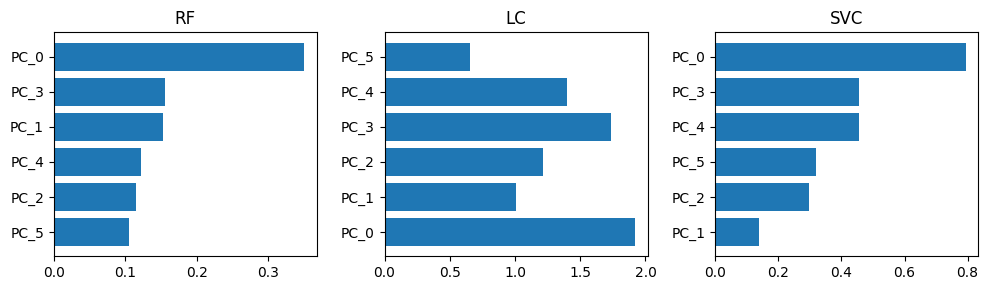

In [20]:
fig, axes = plt.subplots(1,3 , figsize = (10, 3))

for name, model in model_lst : 
    if name =='RF' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_ 
        rf_imp = pd.Series(imp, feature).sort_values()

        axes[0].barh(rf_imp.index, rf_imp.values)
        axes[0].set_title(f'{name}')

    elif name == 'LC' : 
        odd = np.exp(model.coef_[0]) 
        feature = model.feature_names_in_
        lc_imp = pd.Series(odd, index = feature)

        axes[1].barh(lc_imp.index, lc_imp.values)
        axes[1].set_title(f'{name}')

    else : 
        imp = abs(model.coef_).mean(axis = 0)
        feature = model.feature_names_in_
        svc_imp = pd.Series(imp, feature).sort_values()

        axes[2].barh(svc_imp.index, svc_imp.values)
        axes[2].set_title(f'{name}')


plt.tight_layout()
        

In [21]:
## 2번째 

In [22]:
sb_2021 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_sb_2021.csv')
sb_2022 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_sb_2022.csv')
sb_2023 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_sb_2023.csv')


In [23]:
sb = pd.concat([sb_2021, sb_2022, sb_2023], axis = 0)
sb.shape

(182790, 22)

In [24]:
w_2021 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_w_2021.csv')
w_2022 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_w_2022.csv')
w_2023 = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/p2_w_2023.csv')


w = pd.concat([w_2021, w_2022, w_2023], axis = 0)
w.shape

(26280, 10)

In [25]:
sb['sum']= sb.iloc[:,4:].sum(axis = 1)

sb = sb[sb['sum'] !=0].reset_index(drop = True)

# 182790
sb = sb.drop(columns ='sum', axis = 1)
sb.shape
sb.head()

,날짜,호선,역번호,승하차구분,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
0,2021-01-01,A,201,승차,22.0,25,61,64,58,53,...,109,149,196,168,178,177,117,138,90,58
1,2021-01-01,A,201,하차,12.0,49,87,142,101,110,...,105,125,114,86,119,63,26,25,62,18
2,2021-01-01,A,202,승차,43.0,53,70,119,94,103,...,331,323,437,447,881,531,335,441,403,137
3,2021-01-01,A,202,하차,21.0,154,238,727,425,356,...,330,342,321,333,331,163,119,110,137,47
4,2021-01-01,A,203,승차,21.0,27,48,81,62,60,...,156,197,197,203,213,190,145,208,135,76


In [26]:
melt_sb = sb.melt(id_vars = ['날짜','호선', '역번호', '승하차구분'], var_name = '시간', value_name = '인원수')
melt_sb.head(4)
#melt_sb = sb.melt(id_vars = ['날짜','호선','역번호','승하차구분'] , var_name = '시간', value_name = '인원수')
#melt_sb.head(4)

,날짜,호선,역번호,승하차구분,시간,인원수
0,2021-01-01,A,201,승차,X5,22.0
1,2021-01-01,A,201,하차,X5,12.0
2,2021-01-01,A,202,승차,X5,43.0
3,2021-01-01,A,202,하차,X5,21.0


In [27]:
pivot_sb = pd.pivot_table(melt_sb, index = ['날짜','시간','호선','역번호'] , 
               columns = '승하차구분', 
               values = '인원수', 
               aggfunc = 'sum').reset_index()

pivot_sb.columns.name = ''
pivot_sb

,날짜,시간,호선,역번호,승차,하차
0,2021-01-01,X10,A,201,53.0,110.0
1,2021-01-01,X10,A,202,103.0,356.0
2,2021-01-01,X10,A,203,60.0,118.0
3,2021-01-01,X10,A,204,57.0,99.0
4,2021-01-01,X10,A,205,146.0,210.0
...,...,...,...,...,...,...
1636231,2023-12-31,X9,B,338,200.0,166.0
1636232,2023-12-31,X9,B,339,644.0,622.0
1636233,2023-12-31,X9,B,340,213.0,146.0
1636234,2023-12-31,X9,B,341,252.0,115.0


In [28]:
def fill_na(x) : 
    return 0 if pd.isna(x) else x 

na_sb = pivot_sb.applymap(fill_na)
na_sb.isna().sum()

na_sb.head(3)


,날짜,시간,호선,역번호,승차,하차
0,2021-01-01,X10,A,201,53.0,110.0
1,2021-01-01,X10,A,202,103.0,356.0
2,2021-01-01,X10,A,203,60.0,118.0


In [29]:
na_sb['users'] = na_sb['승차'] + na_sb['하차']

In [30]:
na_sb['날짜'] = pd.to_datetime(na_sb['날짜']
                             + ' ' 
                             + na_sb['시간'].str.split('X').str[1].str.zfill(2) +':00' )
na_sb

,날짜,시간,호선,역번호,승차,하차,users
0,2021-01-01 10:00:00,X10,A,201,53.0,110.0,163.0
1,2021-01-01 10:00:00,X10,A,202,103.0,356.0,459.0
2,2021-01-01 10:00:00,X10,A,203,60.0,118.0,178.0
3,2021-01-01 10:00:00,X10,A,204,57.0,99.0,156.0
4,2021-01-01 10:00:00,X10,A,205,146.0,210.0,356.0
...,...,...,...,...,...,...,...
1636231,2023-12-31 09:00:00,X9,B,338,200.0,166.0,366.0
1636232,2023-12-31 09:00:00,X9,B,339,644.0,622.0,1266.0
1636233,2023-12-31 09:00:00,X9,B,340,213.0,146.0,359.0
1636234,2023-12-31 09:00:00,X9,B,341,252.0,115.0,367.0


In [31]:
## w 데이터 - 직전값 FFILL 
for col in w.columns : 
    if col == '강수량' : 
        w[col] = w[col].fillna(0)
    elif w[col].isna().sum() > 0 : 
        w[col] = w[col].fillna(method = 'ffill') 

In [32]:
## w 데이터 
w['일시'] = pd.to_datetime(w['일시'])

In [33]:
## Merge 
na_sb = na_sb[['날짜','호선', '역번호','승차','하차','users']]
merge_df = pd.merge(na_sb, w, how = 'left', left_on = '날짜', right_on = '일시').drop(columns = '일시', axis = 1)
merge_df

,날짜,호선,역번호,승차,하차,users,기온,강수량,풍속,습도,증기압,현지기압,전운량,중하층운량,지면온도
0,2021-01-01 10:00:00,A,201,53.0,110.0,163.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
1,2021-01-01 10:00:00,A,202,103.0,356.0,459.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
2,2021-01-01 10:00:00,A,203,60.0,118.0,178.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
3,2021-01-01 10:00:00,A,204,57.0,99.0,156.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
4,2021-01-01 10:00:00,A,205,146.0,210.0,356.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636231,2023-12-31 09:00:00,B,338,200.0,166.0,366.0,1.1,3.9,2.4,98,6.5,1002.2,10.0,10,-0.1
1636232,2023-12-31 09:00:00,B,339,644.0,622.0,1266.0,1.1,3.9,2.4,98,6.5,1002.2,10.0,10,-0.1
1636233,2023-12-31 09:00:00,B,340,213.0,146.0,359.0,1.1,3.9,2.4,98,6.5,1002.2,10.0,10,-0.1
1636234,2023-12-31 09:00:00,B,341,252.0,115.0,367.0,1.1,3.9,2.4,98,6.5,1002.2,10.0,10,-0.1


In [34]:
merge_df['weekend'] = merge_df['날짜'].dt.dayofweek.map(lambda x : 1 if x in [5,6] else 0)

In [35]:
# 21년, 22년 - train
# 23년 - test 

train_set = merge_df.loc[merge_df['날짜'].dt.year.isin([2021,2022])].reset_index(drop = True)
test_set = merge_df.loc[merge_df['날짜'].dt.year.isin([2023])].reset_index(drop = True)

In [36]:
# 전체 년도에 대한 users와 상관관계 
# 주말여부에 따른 users 의 변수의 차이 

In [37]:
col = ['날짜','호선','역번호','weekend','승차','하차']
cor_df = merge_df.loc[:, merge_df.columns.difference(col)]
cor = cor_df.corr()
cor[cor.index =='users']

,users,강수량,기온,습도,전운량,중하층운량,증기압,지면온도,풍속,현지기압
users,1.0,-0.003306,0.032292,-0.051947,-0.008708,-0.013331,0.000272,0.023862,0.051441,-0.011956


In [38]:
# 주말여부에 따른 users 의 변수의 차이 - 그룹으로 나누지 않고 하는 방법 
from scipy.stats import shapiro, levene, ttest_ind 

g = merge_df.groupby('weekend')['users'].apply(list)

# 1) 정규성 
res = []
for group in g.index : 
    data = g[group]
    stat, p_val = shapiro(data) 
    p_leven = levene(g[0], g[1]).pvalue 

    res.append([group, p_val, p_leven])
        
stat_res = pd.DataFrame(res, columns = ['Group','Shapiro','Levene'])
stat_res['shapiro_check'] = stat_res['Shapiro'].apply(lambda x : '정규성 만족' if x > 0.05 else '정규성 만족 하지 않음')
stat_res['levene_check'] = stat_res['Levene'].apply(lambda x : '등분산' if x > 0.05 else '이분산' )
stat_res

stat, p = ttest_ind(g[0], g[1], equal_var = False)
print(p)

0.0


In [61]:
# 통계 
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/s1.csv')
df.head()

,year,month,day,A,B
0,2023,Sep,7,56.9,42.3
1,2023,Feb,20,100.0,89.0
2,2023,Jun,15,19.3,59.0
3,2023,Apr,11,98.0,84.8
4,2023,Jul,8,89.5,63.8


In [62]:
# 결측치 및 기초 통계량 
print(df.isna().sum())

year     0
month    0
day      0
A        5
B        5
dtype: int64


In [63]:
# 기초 통계량 
df['date']= pd.to_datetime(df['year'].astype(str) + df['month'] + df['day'].astype(str), format ='%Y%b%d')
df['ym'] = df['date'].dt.strftime('%Y-%m') 

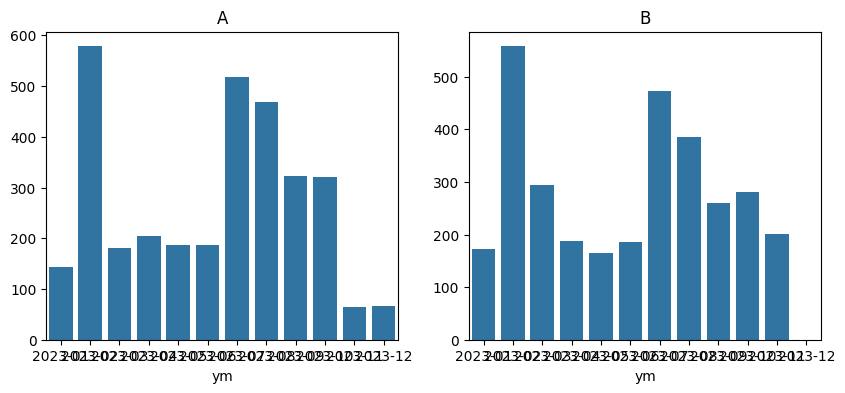

In [67]:
plot_df = df[['A','B','ym']]

fig, axes = plt.subplots(1,2, figsize = (10, 4))

for i, col in enumerate(plot_df.columns) : 
    if col != 'ym' : 
        target = plot_df.groupby('ym')[col].sum()
        sns.barplot(x= target.index, y = target.values, ax = axes[i])
        axes[i].set_title(f'{col}')

plt.show()

In [78]:
# A,B 불량률 평균대체 
for col in df.columns : 
    if df[col].isna().sum() > 0 : 
        df[col] = df[col].fillna(df[col].mean())

print(df.isna().sum())

year     0
month    0
day      0
A        0
B        0
date     0
ym       0
dtype: int64


In [85]:
# A,B 불량률의 차이 
res = []
for ab in  df[['A','B']].columns : 
    stat, p_val = shapiro(df[ab]) 
    res.append([ab, p_val])
    
if any(p_val < 0.05 for _, p_val in res) : 
    print('정규분포가 아니다.') 
    stat, m_p_val = stats.mannwhitneyu(df['A'], df['B'])
    print(f'{m_p_val}')

else : 
    print('정규분포이다') 
    stat, t_p_val = stats.ttest_ind(df['A'], df['B'])
    print(f'{t_p_val}')

정규분포가 아니다.
0.377411102998617


In [87]:
## 통계 2 
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/s2.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지연ID    833 non-null    object
 1   지연일자    833 non-null    object
 2   노선      833 non-null    object
 3   최대지연시간  833 non-null    object
dtypes: object(4)
memory usage: 26.2+ KB
None


,지연ID,지연일자,노선,최대지연시간
0,ID_0,2023-09-01,1호선,15분
1,ID_1,2023-09-01,1호선,15분
2,ID_2,2023-09-01,4호선,10분
3,ID_3,2023-09-01,4호선,10분
4,ID_4,2023-09-04,4호선,10분


In [88]:
df['지연일자'] = pd.to_datetime(df['지연일자']) 

In [91]:
df['최대지연시간'] = df['최대지연시간'].str.split('분', expand = True)[0].astype(int)

In [103]:
# 노선에 상관없이 일별 최대 지연시간이 5~15분으로 발생하는 경우는 하나의 사건으로 보자. 
# 해당 사건이 일자별 발생하는 빈도가 푸아송분포를 따르는지 확인하는 방법 2가지를 기술하고 결과

# 1 . 5-15분 데이터만 추출 
p_df = df[(df['최대지연시간'] >= 5) & (df['최대지연시간'] <= 15)]

# 2. 날짜 별로 중복된 지연이라도 하루에 하나의 사건으로 간주 (unique date count)
# 5~15분 사이의 모든 카운드 
count_all = p_df.groupby(['지연일자']).size().reset_index(name = '사건수')
count_all['지연일자'] = pd.to_datetime(count_all['지연일자'])
count_all.head()

,지연일자,사건수
0,2023-09-01,4
1,2023-09-04,2
2,2023-09-05,3
3,2023-09-06,4
4,2023-09-08,4


0.8072348628390171


{'Chi-square 검정 p-value': np.float64(0.8072),
 '평균 (λ 추정값)': np.float64(2.9255),
 '분산': np.float64(1.7621),
 '평균 ≈ 분산 여부': np.False_}

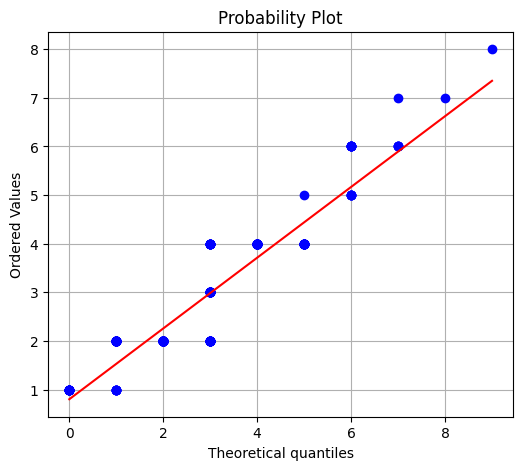

In [124]:
import numpy as np
import scipy.stats as stats
# 1. 푸아송 분포 적합성 검정 (2가지)
# 1.1 Chi-squre 검정 

# 사건수 
cnt = count_all['사건수']

# 평균
mu = cnt.mean()

# 실제 빈도 
observed_freq = cnt.value_counts().sort_index()

# 기대도수 계산 : [1, 2, 3, 4, 5, 6, 7, 8]
k_values = np.arange(observed_freq.index.min() , observed_freq.index.max() + 1)
expected_probs = stats.poisson.pmf(k_values, mu)
expected_freq = expected_probs * len(cnt)

# 기대 도수 총합을 관측 도수에 맞게 조정 
expected_freq = expected_freq * (observed_freq.sum() / expected_freq.sum())

stat, p_val, stats.chisquare(f_obs = observed_freq.values, f_exp=expected_freq[:len(observed_freq)])

print(p_val)

# QQ-plot + Mean_Variance 검토 
plt.figure(figsize = (6,5))
stats.probplot(cnt, dist = stats.poisson(mu) , plot =plt)
plt.grid(True)

# 8. 평균 vs 분산 비교
sample_mean = cnt.mean()
sample_var = cnt.var()

{
    "Chi-square 검정 p-value": round(p_val, 4),
    "평균 (λ 추정값)": round(sample_mean, 4),
    "분산": round(sample_var, 4),
    "평균 ≈ 분산 여부": abs(sample_mean - sample_var) < 0.5
}


# p-value > 0.05 임으로 귀무가설을 기각, 푸아송 분포를 따른다. 
# 푸아송 모델 : 평균과 분산이 유사한가. 
# 단위 시간/공간당 무작위 사건의 개수를 설명하며, "평균과 분산이 동일하다"

In [131]:
#  6-2 10분이하, 10분초과 -20분 이하, 20분초과 3가지로 지연시간을 지연정도로 분류하라. 
# 호선별 지연정도를 교차표
# 지하철 호선별로 지연정도가 차이가 있는지 확인하려한다. 귀무가설과 대립가설을 설정한 후 통계 검정
def delay(x) : 
    if x <= 10 : 
        return '10분이하' 
    elif 10 < x <= 20 : 
        return '20분이하' 
    else : 
        return '20분 초과'


df['지연구분'] = df['최대지연시간'].apply(delay)

tab = pd.crosstab(df['노선'], df['지연구분']) 
stat, p_val, dof, expected = stats.chi2_contingency(tab)

print(f'''
귀무가설 : 지하철 호선별로 지연정도는 독립이다.
대립가설 : 지하철 호선별로 지연정도는 독립이 아니다.

{p_val} < 0.05로 귀무가설을 기각하여, 지하철 호선별로 지연정도는 독립이 아니다.
즉, 지하철 호선별로 지연정도의 분포가 달라진다.
''')


귀무가설 : 지하철 호선별로 지연정도는 독립이다.
대립가설 : 지하철 호선별로 지연정도는 독립이 아니다.

0.000974872502884969 < 0.05로 귀무가설을 기각하여, 지하철 호선별로 지연정도는 독립이 아니다.
즉, 지하철 호선별로 지연정도의 분포가 달라진다.



In [133]:
## 통계 3
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_33/s3.csv')
print(df.info())
df.columns = ['value']
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   0.4967141530112327  249 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


,value
0,0.308778
1,0.692133
2,2.070861
3,1.326845
4,0.077552


In [ ]:
#ar ma arma에 대해 설명하고, ACF, PACF는 패턴을 통해 설명
print('''
AR (자기 회귀 모형) : 현재 시점 데이터가 과거의 자기 자신 값들에 의존하여 생성된다는 것으로 가정 
    즉, 시계열의 과거 값들의 선형적 결합으로 현재 값을 설명하는 구조로, 일정한 자기 상관이 존재할 때의 모델 

MA (이동 평균 모형) : 현재의 데이터가 과거의 오차항 (예측 오차)의 선형 결합으로 이루어지며, 
    과거의 불규칙성이 현재 값에 영향을 준다고 해석한다. 시계열의 잡음을 반영 

ARMA - AR과 MA의 모형을 결합한 상태로, 과거의 값과 과거의 예측오차(오차항)에 영향을 받아 현재 값을 형성 

ACF, PACF를 통해 확인 할 수 있으며, 
PACF가 특정 시차에 절단되면 AR모델 
ACF가 절단되면 MA 모형, 둘 다 점차 감소하면 ARMA 모델을 고려한다. 

''')

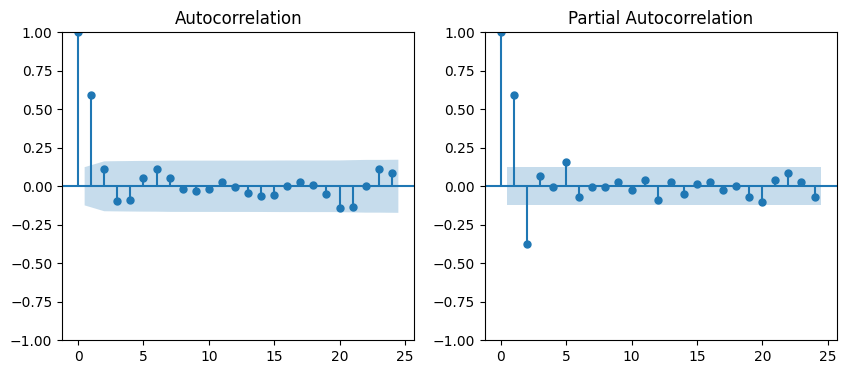

In [134]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf


fig, ax = plt.subplots(1,2, figsize = (10, 4))
plot_acf(df, ax = ax[0])
plot_pacf(df, ax = ax[1])
plt.show()

In [ ]:
print('''
1) ACF [왼쪽] - MA
    - 1,2 에서 자기 상관이 존재, 이후 0근처에서 변동 
    - 자수적으로 감소하는 모양으로  AR계열의 특성 
    [AR 특징] : 앞에서 조금씩 유의미한 값이 남아있다가 서서히 사라지는 형태
    [MA(q) = 0 인 이유] : MA(1)이였다면 Lag 1에서 유의하고 Lag 2부터는 완전히 0 
                         MA(2) 였다면, Lag 1,2 에서 유의하고 Lag 3부터는 완전히 0 
                         하지만, 0으로 가기까지 조금씩 남아있다가 "지수적으로" 줄어는 형태임으로 점진적 감소

2) PACF [오른쪽] - AR
    - Lag 1에서는 뚜렷하게 유의 
    - Lag 2이후 부터는 0에 수렴 
    - PACF 3차에서 절단 된다고 해석 

추천 모형 ARMA(3,0)
''')